<a name='Image-Captioning-Models'></a>
# **Image Captioning Models**

The goal of this project as explained before, is to create an image captioning model that can generate descriptive and accurate captions for images. To achieve this, we first explored the dataset and cleaned the captions, by visualizing the distribution of caption lengths, we determined the maximum caption length. We then utilized pre-trained CNN models, VGG16 and DenseNet201, to extract image features which will be passed through an LSTM model to generate captions. To enhance the quality of the captions, we will also utilize GloVe embeddings to represent the words in the captions, allowing the model to better understand the semantic meaning of the words. During training, the models will be trained using a large dataset of image-caption pairs, and the weights of the model will be updated using backpropagation to minimize the loss function. Once trained, the model can be used to generate captions for new images by passing the image through the CNN and then feeding the extracted features into the LSTM to generate the caption word by word. Overall, the CNN-LSTM combination is a powerful approach for image captioning that leverages the strengths of both architectures, and has been shown to achieve state-of-the-art results on various benchmarks.

## **Text-To-Speech Systems**
Text-to-speech is the process of converting written text into spoken words. This technology has numerous applications, including assisting people with visual impairments to access digital content such as web pages, books, and other forms of text-based media.

In the context of our project, text-to-speech can be used to generate audio descriptions for the images that we have captioned. This can be particularly useful for blind or visually impaired individuals who may not be able to see the images themselves, but can still benefit from a verbal description of the content.

To generate audio descriptions for the images in our project, we will use gTTS to convert the image captions into spoken words.

## **Contents:**
- [Image Captioning Models](#Image-Captioning-Models)
- [Imports](#Imports)
- [Functions](#Functions)
- [Data Generation](#Data-Generation)
- [Tokenization and Encoded Representation](#Tokenization)
- [Train-Test-Split Dataset](#Train-Test-Split)
- [Model with GloVe's Pretrained Embeddings](#Glove-Embedding)
- [Modelling With Extracted Image Features From DenseNet201](#Modelling-dns)
- [Modelling With Extracted Image Features From VGG16](#Modelling-vgg)
- [Save Models](#Save-Models)
- [Text-To-Speech System For Generated Captions](#Text-To-Speech)
- [Conclusions and Recommendations](#Conclusion-and-Recommendations)

<a name='Imports'></a>
## **Imports**

In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from textwrap import wrap
import pickle
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import Sequence, to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, Reshape, Embedding, concatenate, LSTM, Dropout, add
from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

pd.set_option("display.max_colwidth", None)

### **Load Data**

In [ ]:
# Mount to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Read cleaned caption file
df = pd.read_csv('drive/MyDrive/Colab Notebooks/Capstone_Project/data/cleaned_caption.csv')

# Define the path of data
image_path = 'drive/MyDrive/Colab Notebooks/Capstone_Project/data/Images'

# Load extracted image features with DenseNet201
with open('drive/MyDrive/Colab Notebooks/Capstone_Project/data/extracted_image_features/densenet_img_feature_ex.pkl', 'rb') as pickle_in:
    img_features_dns = pickle.load(pickle_in)

# Load extracted image features with VGG16
with open('drive/MyDrive/Colab Notebooks/Capstone_Project/data/extracted_image_features/vgg16_img_feature_ex.pkl', 'rb') as pickle_in:
    img_features_vgg = pickle.load(pickle_in)

<a name='Functions'></a>
## **Functions**

- Below functions are for predicting the caption based on the image input and also displaying samples of predictions.

In [ ]:
# Function for returning the word if the word index is equal to the input integer
def idx_to_word(integer,tokenizer):
    
    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

# Function for predicting the caption
def predict_caption(model, image, tokenizer, max_length, features):
    
    feature = features[image]
    in_text = 'startsen'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]   # Convert the text data to a numerical format that can be fed into embedding layer
        sequence = pad_sequences([sequence], max_length)        # Pad sequences to a specified length (max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)                              # Find the index of the class with the highest probability in the
                                                                # probability distribution over the classes after softmax() function in our model
        word = idx_to_word(y_pred, tokenizer)                   # Used idx_to_word function for generating the word
        
        if word is None:
            break
            
        in_text += ' ' + word                                   # Add generated word to the text
        
        if word == 'endsen':
            break
            
    return in_text

In [ ]:
# Read and display Image data
def read_images(path, img_size=224):
    
    # Load the image from file
    img = load_img(path, color_mode='rgb', target_size=(img_size, img_size))
    
    # Convert image pixels to array
    img = np.array(img)
    
    # Dividing by the maximal value
    img = img/255
    
    return img 

def display_images(sam_data, num_images):
    
    # Reset the index of sample data
    sam_data = sam_data.reset_index(drop=True)
    
    # Defining the plot size
    plt.figure(figsize = (12,8))
    
    n = 0
    
    for i in range(num_images):
        n += 1
        
        # Number of images in columns and rows of each subplot
        plt.subplot(3, 3, n)
        
        # Adjust the subplot layout parameter
        plt.subplots_adjust(hspace=1.2, wspace=1)
        
        # Define the path of the image
        path = image_path + '/' + sam_data['image'][i]
        
        # Execute the function on path
        image = read_images(path)
        
        # Show the image with it's caption
        plt.imshow(image)
        plt.title("\n".join(wrap(sam_data.caption[i], 20)))
        plt.axis('off')

- Below function is for plotting the trend of the accuracy and loss for a model over the course of all epochs for both training and test data

In [ ]:
def plot_history(hist):
    """Plots the accuracy and loss for a model over the course of all epochs
    
    Parameters:
        hist (keras history object): The recorded history of model.fit() to be plotted
    """
    fig, axs = plt.subplots(2, 1, figsize=(8,7))
    fig.tight_layout(pad=2)
    
    # Accuracy subplot
    axs[0].plot(hist.history["acc"], c='navy', label="Training Accuracy")
    axs[0].plot(hist.history["val_acc"], c='orange', label="Validation Accuracy")    
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy")
    
    # Error subplot
    axs[1].plot(hist.history["loss"], c='navy', label="Training Loss")
    axs[1].plot(hist.history["val_loss"], c='orange', label="Validation Loss")    
    axs[1].set_ylabel("Loss")
    axs[1].set_xlabel("Epochs")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Loss")
    
    plt.show()

<a name='Data-Generation'></a>
## **Data Generation**

Using a data generator has several advantages over loading all of the data into memory at once. First, it allows for efficient memory usage since only one batch of data is loaded into memory at a time. Second, it enables the use of larger datasets that would otherwise be too large to fit in memory. Finally, it allows for more flexibility in data preprocessing since the preprocessing can be done on-the-fly during training rather than beforehand.
In the following class, the inputs will be the image embeddings and their corresonding caption text embeddings for the training process. The text embeddings are passed word by word for the caption generation during inference time.

In [ ]:
class CustomDataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features,shuffle=True):
    
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
    
    # Shuffles the data at the end of each epoch
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    # Returns the number of batches per epoch
    def __len__(self):
        return self.n // self.batch_size
    
    # Returns a batch of data: It first selects the rows of the dataframe that correspond to the current batch.
    # Then calls the __get_data() method to generate the input and output data.
    def __getitem__(self,index):
        
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)        
        return (X1, X2), y
    
    # Method that takes a batch of data and returns the input and output data   
    def __get_data(self,batch):
        
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
        
        # It loops over the rows of the batch and for each image and caption pair
        for image in images:
            feature = self.features[image][0]
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            
            # It generates all possible input-output pairs
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    
                    # It tokenizes the caption using the tokenizer object, pads the input sequence to max_length
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    
                    # One-hot encodes the output sequence using to_categorical()
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    
                    # Then adds these input-output pairs to the corresponding lists X1, X2, and y
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
                    
        # Finally, it returns these lists as numpy arrays    
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
        
        return X1, X2, y

<a name='Tokenization'></a>
## **Tokenization and Encoded Representation**

The words in a sentence are separated/tokenized and encoded in a one hot representation. These encodings are then passed to the embeddings layer to generate word embeddings.

In [ ]:
# Get list of captions
captions = df['caption'].tolist()

# Create tokenizer and apply on captions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
max_tokens = len(tokenizer.word_index) + 1

# Find maximun length of the caption text
max_length = max([len(caption.split()) for caption in captions])
print(f'Maximum caption length based on the number of words: {max_length}')

Maximum caption length based on the number of words: 34


<a name='Train-Test-Split'></a>
## **Train-Test-Split Dataset**

In [ ]:
# Make a list of images id and get the number of ids
images = df['image'].unique().tolist()
num_images = len(images)

# Define split_index to determine the size of test/train data
split_index = round(0.85*num_images)

# Split data into train and test datasets
train_images = images[:split_index]
test_images = images[split_index:]
train = df[df['image'].isin(train_images)].reset_index(drop=True).drop(columns='Unnamed: 0')
test = df[df['image'].isin(test_images)].reset_index(drop=True).drop(columns='Unnamed: 0')

<a name='Glove-Embedding'></a>
## **Model with GloVe's Pretrained Embeddings**

Cite: "https://analyticsindiamag.com/hands-on-guide-to-word-embeddings-using-glove/#:~:text=The%20basic%20idea%20behind%20the,pair%20of%20words%20occurring%20together."

The basic idea behind the GloVe word embedding is to derive the relationship between the words from statistics.  Unlike the occurrence matrix, the co-occurrence matrix tells you how often a particular word pair occurs together. Each value in the co-occurrence matrix represents a pair of words occurring together.

### **Get GloVe Word Vectors**

In [ ]:
# The GloVe file has been downloaded before and here we just open it from our google drive
# however th following link is provided for downloading and unzipping this file
# #!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip -q glove.6B.zip
glove_embedding = {}

with open('drive/MyDrive/Colab Notebooks/Capstone_Project/data/glove.6B/glove.6B.200d.txt') as glove_file:
    for line in glove_file:
        values = line.split()
        word = values[0]
        word_vector = np.asarray(values[1:], 'float32')
        glove_embedding[word] = word_vector

In [ ]:
embedding_dim = 256

# Create a huge embedding matrix based on GloVe for caption words
# 1 row = 1 word vector
embedding_matrix = np.zeros((max_tokens, embedding_dim))
zero_array = [0]*56

for i, word in tokenizer.index_word.items():
    if i < max_tokens:
        vector = glove_embedding.get(word)
        if vector is not None:
            embedding_matrix[i] = np.concatenate((vector, zero_array))

<a name='Modelling-dns'></a>
## **Modelling With Extracted Image Features From DenseNet201**
- The image embedding representations are concatenated with the first word of sentence ie. starsen and passed to the LSTM network
- The LSTM network starts generating words after each input thus forming a sentence at the end

In [ ]:
# Determine maximum caption length based on the number of words ditribution in 01_EDA_and_Cleaning
max_caption_length = 25

In [ ]:
# Define input layer for images and captions 
# 1920 represents the number of extracted features from DensNet201
img_input_layer = Input(shape=(1920,))
caption_input_layer = Input(shape=(max_caption_length,))

# Define layers to extract features from images and captions 

# Feature extraction layers for image
img_features_layer = Dense(256, activation='relu')(img_input_layer)
img_features_reshaped_layer = Reshape((1, 256), input_shape=(256,))(img_features_layer)

# Feature extraction layers for Captions
caption_features_layer = Embedding(input_dim = max_tokens,
                            output_dim = 256,
                            embeddings_initializer = Constant(embedding_matrix),
                            input_length = max_caption_length,
                            trainable = False)(caption_input_layer)

# Combine extracted features from image and caption
combined_layers = concatenate([img_features_reshaped_layer, caption_features_layer], axis=1)

# Pass the combined layer to LSTM to predict words in captions
caption_features_layer = LSTM(256)(combined_layers)

# Drop out for normalizing
x = Dropout(0.5)(caption_features_layer)

# Adding image feature layer to generated caption feature layer
x = add([x, img_features_layer])

# Adding a hidden dense layer with 128 neurons 
x = Dense(128, activation='relu')(x)

# Drop out for normalizing
x = Dropout(0.5)(x)

# Make the output based on the max_tokens
output = Dense(max_tokens, activation='softmax')(x)

caption_model_dns = Model(inputs=[img_input_layer,caption_input_layer], outputs=output)
# caption_model.layers

caption_model_dns.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1920)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 256)          491776      ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 25)]         0           []                               
                                                                                                  
 reshape (Reshape)              (None, 1, 256)       0           ['dense[0][0]']                  
                                                                                              

In [ ]:
# Here in google colab there was no need to download anything for having plot_model()
# however if anyone wants to have that following plot in jupyter notebook, there is 
# a need for running following code in command line
# !pip install pydot
# !winget install -e --id Graphviz.Graphviz
# plot_model(caption_model)

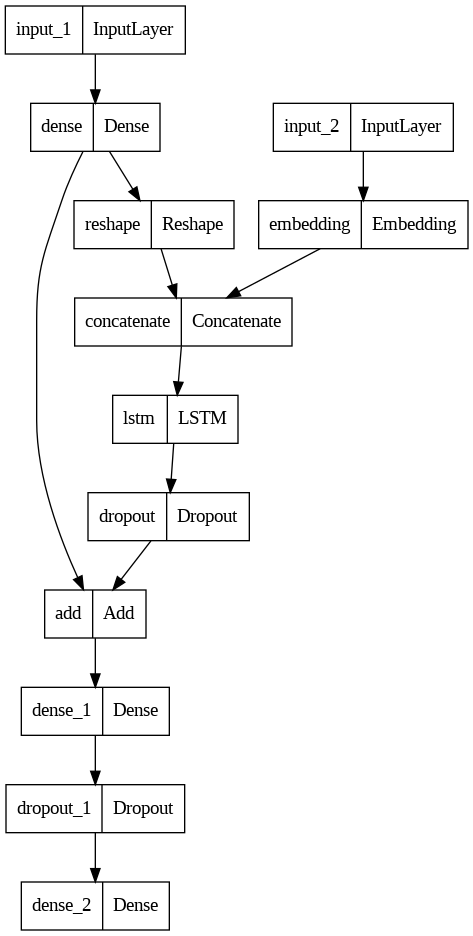

In [ ]:
# Compile the model
caption_model_dns.compile(loss='categorical_crossentropy',  # loss for multi-class classification
                      optimizer='adam',
                      metrics=['acc'])                      # The other metric is accuracy score
plot_model(caption_model_dns)

In [ ]:
# Create train and validation data generators to create batchwise data
train_generator = CustomDataGenerator(df = train,
                                      X_col = 'image',
                                      y_col = 'caption',
                                      batch_size = 64,
                                      directory = image_path,
                                      tokenizer = tokenizer,
                                      vocab_size = max_tokens,
                                      max_length = max_caption_length,
                                      features = img_features_dns)

validation_generator = CustomDataGenerator(df = test,
                                           X_col = 'image',
                                           y_col = 'caption',
                                           batch_size = 64,
                                           directory = image_path,
                                           tokenizer = tokenizer,
                                           vocab_size = max_tokens,
                                           max_length = max_caption_length,
                                           features = img_features_dns)

In [ ]:
# Define callbacks

model_name = "model.h5"  # The file where the model weights will be saved (for checkpoints)

checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",                 # Monitoring validation loss
                            mode="min",                         # The direction to minimazing val loss
                            save_best_only = True,              # Weights will only be saved if the monitored quantity improves
                            verbose=1)                          # Progress updates will be printed

earlystopping = EarlyStopping(monitor='val_loss',               # Monitoring validation loss
                              min_delta = 0,                    # Any improvement will be considered
                              patience = 5,                     # Specifies the number of epochs with no improvement
                              verbose = 1,                      # Progress updates will be printed
                              restore_best_weights=True)        # Weights of the model with the lowest val_loss will be restored

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', # Monitoring validation loss
                                            patience=3,         # specifies the number of epochs with no improvement after which the learning rate will be reduced
                                            verbose=1,          # Progress updates will be printed
                                            factor=0.2,         # Learning rate will be reduced by a factor of 0.2
                                            min_lr=0.00000001)  # Learning rate will not be reduced below this value

In [ ]:
# Fit the model
history_dns = caption_model_dns.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/50
537/537 [==============================] - ETA: 0s - loss: 5.1997 - acc: 0.1760
Epoch 1: val_loss improved from inf to 4.35847, saving model to model.h5
537/537 [==============================] - 240s 431ms/step - loss: 5.1997 - acc: 0.1760 - val_loss: 4.3585 - val_acc: 0.2386 - lr: 0.0010
Epoch 2/50
537/537 [==============================] - ETA: 0s - loss: 4.3858 - acc: 0.2343
Epoch 2: val_loss improved from 4.35847 to 4.07590, saving model to model.h5
537/537 [==============================] - 55s 102ms/step - loss: 4.3858 - acc: 0.2343 - val_loss: 4.0759 - val_acc: 0.2589 - lr: 0.0010
Epoch 3/50
537/537 [==============================] - ETA: 0s - loss: 4.1702 - acc: 0.2496
Epoch 3: val_loss improved from 4.07590 to 3.96505, saving model to model.h5
537/537 [==============================] - 54s 101ms/step - loss: 4.1702 - acc: 0.2496 - val_loss: 3.9651 - val_acc: 0.2703 - lr: 0.0010
Epoch 4/50
537/537 [==============================] - ETA: 0s - loss: 4.0431 - acc: 0.25

### **Plot the results**

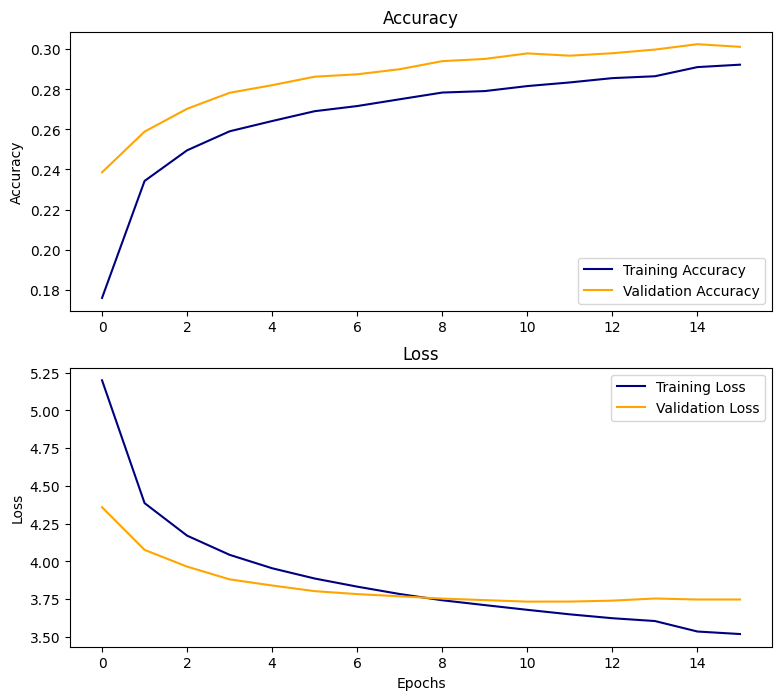

In [ ]:
plot_history(history_dns)

In [ ]:
# Make prediction on sample of test data 
samples = test.sample(15)
samples.reset_index(drop=True,inplace=True)

for index,record in samples.iterrows():

    img = load_img(image_path + '/' + record['image'],target_size=(224,224))   # Load the image                
    img = np.array(img)                                                        # Transform the image into array
    img = img/255                                                              # Normalize the image
    
    captions = predict_caption(caption_model_dns, record['image'], tokenizer, max_caption_length, img_features_dns)                  # Run the predict_caption function for predictiong captions for loaded images
    samples.loc[index,'caption'] = ' '.join([caption for caption in captions.split() if caption not in ['startsen', 'endsen']])      # Remove start and end tag from predicted caption and save them in sample caption column

1/1 [==============================] - 0s 21ms/step


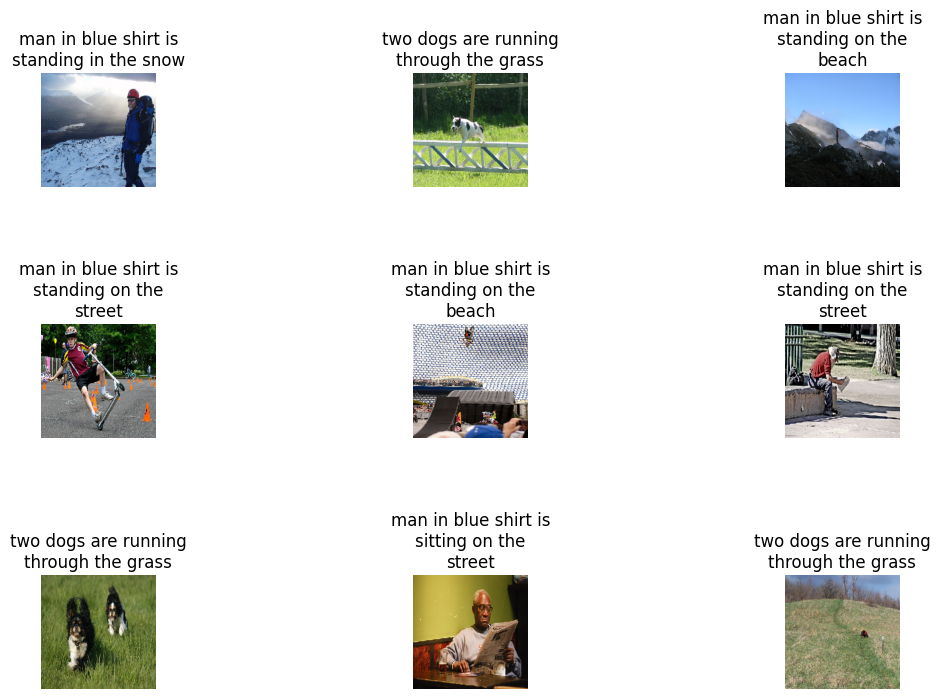

In [ ]:
# Display the test data images with generated captions 
display_images(samples, 9)

<a name='Modelling-vgg'></a>
## **Modelling With Extracted Image Features From VGG16**

- The main difference between following model and the last one is in utilizing extracted image features by VGG16.

In [ ]:
# Define input layer for images and captions
# 4096 represents the number of extracted features from VGG16 
img_input_layer = Input(shape=(4096,))
caption_input_layer = Input(shape=(max_caption_length,))

# Define layers to extract features from images and captions 

# Feature extraction layers for image
img_features_layer = Dense(256, activation='relu')(img_input_layer)
img_features_reshaped_layer = Reshape((1, 256), input_shape=(256,))(img_features_layer)

# Feature extraction layers for Captions
caption_features_layer = Embedding(input_dim = max_tokens,
                            output_dim = 256,
                            embeddings_initializer = Constant(embedding_matrix),
                            input_length = max_caption_length,
                            trainable = False)(caption_input_layer)

# Combine extracted features from image and caption
combined_layers = concatenate([img_features_reshaped_layer, caption_features_layer], axis=1)

# Pass the combined layer to LSTM to predict words in captions
caption_features_layer = LSTM(256)(combined_layers)

# Drop out for normalizing
x = Dropout(0.5)(caption_features_layer)

# Adding image feature layer to generated caption feature layer
x = add([x, img_features_layer])

# Adding a hidden dense layer with 128 neurons
x = Dense(128, activation='relu')(x)

# Drop out for normalizing
x = Dropout(0.5)(x)

# Make the output based on the max_tokens
output = Dense(max_tokens, activation='softmax')(x)

caption_model_vgg = Model(inputs=[img_input_layer,caption_input_layer], outputs=output)
# caption_model.layers

caption_model_vgg.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 256)          1048832     ['input_3[0][0]']                
                                                                                                  
 input_4 (InputLayer)           [(None, 25)]         0           []                               
                                                                                                  
 reshape_1 (Reshape)            (None, 1, 256)       0           ['dense_3[0][0]']                
                                                                                            

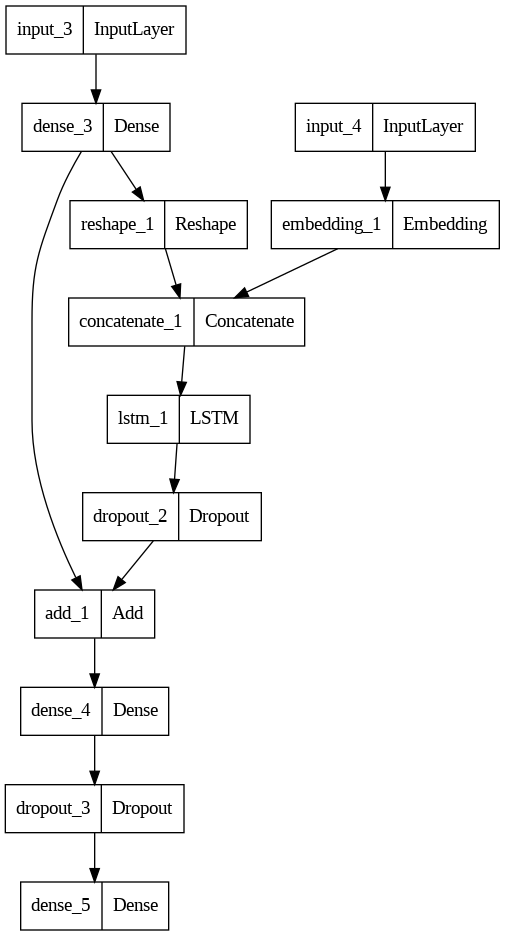

In [ ]:
# Compile the model
caption_model_vgg.compile(loss='categorical_crossentropy',  # loss for multi-class classification
                      optimizer='adam',
                      metrics=['acc'])                      # The other metric is accuracy score
plot_model(caption_model_vgg)

In [ ]:
# Create train and validation data generators to create batchwise data
train_generator = CustomDataGenerator(df = train,
                                      X_col = 'image',
                                      y_col = 'caption',
                                      batch_size = 64,
                                      directory = image_path,
                                      tokenizer = tokenizer,
                                      vocab_size = max_tokens,
                                      max_length = max_caption_length,
                                      features = img_features_vgg)

validation_generator = CustomDataGenerator(df = test,
                                           X_col = 'image',
                                           y_col = 'caption',
                                           batch_size = 64,
                                           directory = image_path,
                                           tokenizer = tokenizer,
                                           vocab_size = max_tokens,
                                           max_length = max_caption_length,
                                           features = img_features_vgg)

In [ ]:
# Define callbacks

model_name = "model.h5"  # The file where the model weights will be saved (for checkpoints)

checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",                 # Monitoring validation loss
                            mode="min",                         # The direction to minimazing val loss
                            save_best_only = True,              # Weights will only be saved if the monitored quantity improves
                            verbose=1)                          # Progress updates will be printed

earlystopping = EarlyStopping(monitor='val_loss',               # Monitoring validation loss
                              min_delta = 0,                    # Any improvement will be considered
                              patience = 5,                     # Specifies the number of epochs with no improvement
                              verbose = 1,                      # Progress updates will be printed
                              restore_best_weights=True)        # Weights of the model with the lowest val_loss will be restored

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', # Monitoring validation loss
                                            patience=3,         # specifies the number of epochs with no improvement after which the learning rate will be reduced
                                            verbose=1,          # Progress updates will be printed
                                            factor=0.2,         # Learning rate will be reduced by a factor of 0.2
                                            min_lr=0.00000001)  # Learning rate will not be reduced below this value

In [ ]:
# Fit the model
history_vgg = caption_model_vgg.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/50
537/537 [==============================] - ETA: 0s - loss: 5.0571 - acc: 0.1836
Epoch 1: val_loss improved from inf to 4.25522, saving model to model.h5
537/537 [==============================] - 277s 510ms/step - loss: 5.0571 - acc: 0.1836 - val_loss: 4.2552 - val_acc: 0.2448 - lr: 0.0010
Epoch 2/50
537/537 [==============================] - ETA: 0s - loss: 4.2124 - acc: 0.2426
Epoch 2: val_loss improved from 4.25522 to 3.94494, saving model to model.h5
537/537 [==============================] - 59s 109ms/step - loss: 4.2124 - acc: 0.2426 - val_loss: 3.9449 - val_acc: 0.2722 - lr: 0.0010
Epoch 3/50
537/537 [==============================] - ETA: 0s - loss: 3.9618 - acc: 0.2619
Epoch 3: val_loss improved from 3.94494 to 3.83132, saving model to model.h5
537/537 [==============================] - 58s 108ms/step - loss: 3.9618 - acc: 0.2619 - val_loss: 3.8313 - val_acc: 0.2828 - lr: 0.0010
Epoch 4/50
537/537 [==============================] - ETA: 0s - loss: 3.8079 - acc: 0.27

### Plot the results

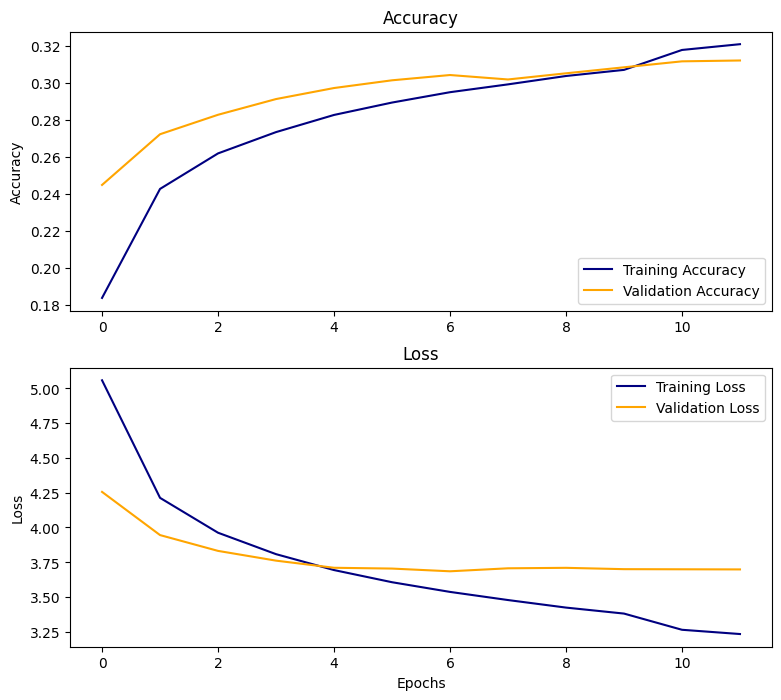

In [ ]:
plot_history(history_vgg)

In [ ]:
# Make prediction on sample of test data 
samples = test.sample(15)
samples.reset_index(drop=True,inplace=True)

for index,record in samples.iterrows():

    img = load_img(image_path + '/' + record['image'],target_size=(224,224))   # Load the image                
    img = np.array(img)                                                        # Transform the image into array
    img = img/255                                                              # Normalize the image
    
    captions = predict_caption(caption_model_vgg, record['image'], tokenizer, max_caption_length, img_features_vgg)                   # Run the predict_caption function for predictiong captions for loaded images
    samples.loc[index,'caption'] = ' '.join([caption for caption in captions.split() if caption not in ['startsen', 'endsen']])      # Remove start and end tag from predicted caption and save them in sample caption column

1/1 [==============================] - 0s 20ms/step


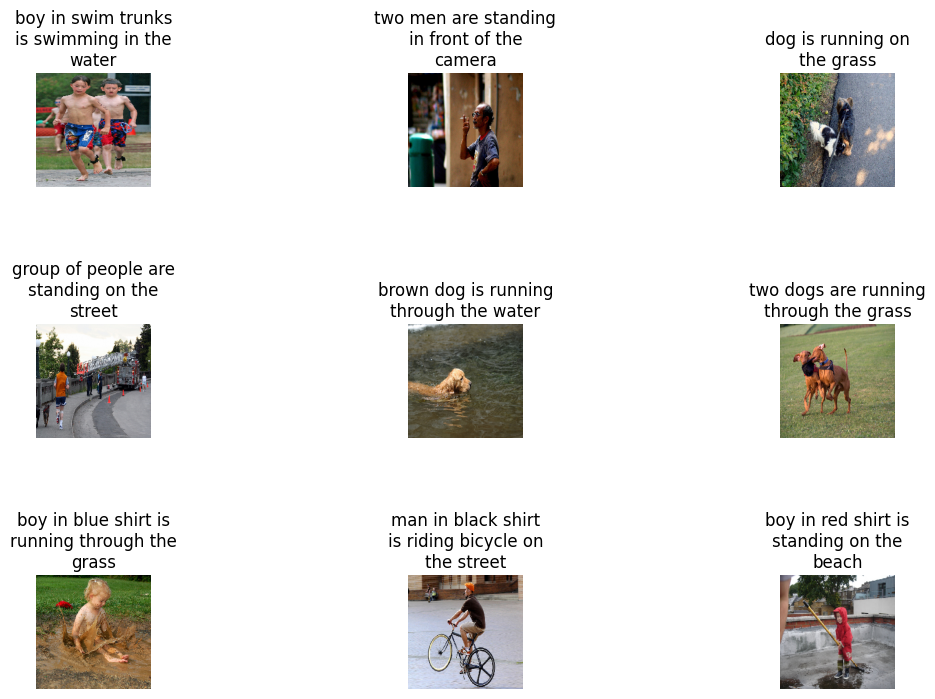

In [ ]:
# Display the test data images with generated captions 
display_images(samples, 9)

<a name='Save-Models'></a>
## Save Models

In [ ]:
caption_model_dns.save('drive/MyDrive/Colab Notebooks/Capstone_Project/model/caption_mode_with_densenet201.h5')

In [ ]:
caption_model_vgg.save('drive/MyDrive/Colab Notebooks/Capstone_Project/model/caption_mode_with_vgg16.h5')

<a name='Text-To-Speech'></a>
## Text-To-Speech System For Generated Captions

In the following we try to generate a caption on one sample "with speech".

In [ ]:
# Install the gTTs
!pip install gTTS pyttsx3 playsound

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for playsound: filename=playsound-1.3.0-py3-none-any.whl size=7035 sha256=fc9fe1789836895cd2c8cd1c0484c3cf87d1b0122d017a2e55094cb3e48eab90
  Stored in directory: /root/.cache/pip/wheels/ba/39/54/c8f7ff9a88a644d3c58b4dec802d90b79a2e0fb2a6b884bf82
Successfully built playsound


1/1 [==============================] - 0s 25ms/step


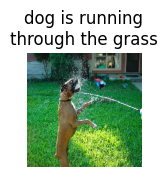

In [ ]:
# Make prediction on a sample of test data 
from gtts import gTTS
from IPython.display import Audio 
samples = test.sample(1)
samples.reset_index(drop=True,inplace=True)

for index,record in samples.iterrows():

    img = load_img(image_path + '/' + record['image'],target_size=(224,224))   # Load the image                
    img = np.array(img)                                                        # Transform the image into array
    img = img/255                                                              # Normalize the image
    
    captions = predict_caption(caption_model_vgg, record['image'], tokenizer, max_caption_length, img_features_vgg)  # Run the predict_caption function for predictiong captions for loaded images
    samples.loc[index,'caption'] = ' '.join([caption for caption in captions.split() if caption not in ['startsen', 'endsen']])      # Remove start and end tag from predicted caption and save them in sample caption column

# Display the test data images with generated captions
display_images(samples, 1)

# Generate the speech from caption
tts = gTTS(' '.join([caption for caption in captions.split() if caption not in ['startsen', 'endsen']]))
tts.save('1.wav')
sound_file = '1.wav'
Audio(sound_file, autoplay=True)

<a name='Conclusion-and-Recommendations'></a>
## **Conclusions and Recommendations**

### **Conclusions**
- Based on the project, we have successfully developed an image captioning model that can generate captions for images. The model combines both Convolutional Neural Network (CNN) and Long Short-Term Memory (LSTM) networks to generate captions that are relevant to the image content. We have also utilized GloVe word embeddings to improve the accuracy of the generated captions.
- To extract the image features, we have used pre-trained models, VGG16 and DenseNet201, and found that final model (CNN-LSTM) performance with VGG16 is slightly better in terms of loss and accuracy score.
- Finally, we have utilized text-to-speech technology to convert the generated captions into audio descriptions for visually impaired individuals.

### **Recommendations**

- We suggest further exploration can be conducted on the impact of different pre-trained models and different word embeddings on the accuracy of the model.
- Additionally, using larger datasets, such as Flickr30k, MSCOCO and SBU can potentially improve the accuracy of the image captioning model as it provides more diverse and comprehensive data for the model to learn from. In addition, working with larger datasets can help to reduce overfitting and increase the generalization ability of the model.
- Moreover, we should consider expanding the application of the model. For example, we could use the same model to generate descriptions for videos or to generate captions for images in a different domain, such as medical imaging.

Overall, this project showcases the potential of using machine learning techniques to develop solutions that can enhance accessibility and inclusivity for people with disabilities.